In [1]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

     ━━━━━━━━

In [2]:
!pip install pyproject-toml

In [3]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import talib

import gym
from gym.envs.registration import register

In [4]:
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.append('/content/drive/My Drive/FYP/')

In [7]:
import training_env

INFO:training_env:training_env logger started.


In [8]:
import evaluation_env

INFO:evaluation_env:evaluation_env logger started.


In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
sns.set_style('whitegrid')

In [11]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [12]:
results_path = '/content/drive/My Drive/FYP/results/federated_learning/'
if not Path(results_path).exists():
    Path(results_path).mkdir(parents=True)

In [13]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

In [14]:
trading_days = 252

In [15]:
register(
    id='trading-v0-training',
    entry_point='training_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [16]:
register(
    id='trading-v0-evaluation',
    entry_point='evaluation_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [17]:
trading_cost_bps = 1e-3
time_cost_bps = 5e-3

In [18]:
f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}'

'Trading costs: 0.10% | Time costs: 0.50%'

In [19]:
trading_environment_training = gym.make('trading-v0-training', ticker='AAPL', trading_days=252, trading_cost_bps=0.001, time_cost_bps=0.0001)
trading_environment_training.seed(42)

INFO:training_env:loading data for AAPL...
INFO:training_env:got data for AAPL...
INFO:training_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7914 entries, (Timestamp('1981-03-19 00:00:00'), 'AAPL') to (Timestamp('2012-07-31 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  7914 non-null   float64
 1   ret_2    7914 non-null   float64
 2   ret_5    7914 non-null   float64
 3   ret_10   7914 non-null   float64
 4   ret_21   7914 non-null   float64
 5   rsi      7914 non-null   float64
 6   macd     7914 non-null   float64
 7   atr      7914 non-null   float64
 8   stoch    7914 non-null   float64
 9   ultosc   7914 non-null   float64
dtypes: float64(10)
memory usage: 1.4+ MB


[42]

In [20]:
state_dim = trading_environment_training.observation_space.shape[0]
num_actions = trading_environment_training.action_space.n
max_episode_steps = trading_environment_training.spec.max_episode_steps

In [21]:
print("state dim:", state_dim)
print("num actions:", num_actions)
print("max episode steps:", max_episode_steps)

state dim: 10
num actions: 3
max episode steps: 252


In [22]:
dataset = trading_environment_training.data_source.data
print(dataset.head())
print(dataset.index.min(), dataset.index.max())

                    returns     ret_2     ret_5    ret_10    ret_21       rsi  \
date       ticker                                                               
1981-03-19 AAPL   -0.009709  1.115062  1.859675 -0.267703 -0.623076  1.449663   
1981-03-20 AAPL    0.009804 -0.053067  2.209204 -0.071944 -0.140935  1.447987   
1981-03-23 AAPL    0.038835  1.057801  2.197587  1.241282  0.547690  1.447987   
1981-03-24 AAPL   -0.004486  0.721391  1.346553  1.772539  0.397581  1.389566   
1981-03-25 AAPL   -0.018776 -0.578311  0.130613  2.030821  0.527521  0.755368   

                       macd       atr     stoch    ultosc  
date       ticker                                          
1981-03-19 AAPL   -0.236118 -0.544853 -0.613605  0.415074  
1981-03-20 AAPL   -0.231525 -0.546024 -0.003333  0.858265  
1981-03-23 AAPL   -0.226013 -0.544796  0.046091  0.974650  
1981-03-24 AAPL   -0.220204 -0.547143  0.238232  1.080699  
1981-03-25 AAPL   -0.214772 -0.548150  1.044555  0.672622  
(Timestamp('

In [23]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state, verbose=False)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        # print(self.idx.shape)
        # print(actions.shape)
        # print(targets.shape)
        #q_values[[self.idx, actions]] = targets#.reshape(-1,4096,3)
        for i, action in enumerate(actions):
          q_values[i, action] = targets[i]
        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

In [43]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

In [44]:
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

In [45]:
replay_capacity = int(5e5)
batch_size = 256

In [46]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [47]:
tf.keras.backend.clear_session()

In [48]:
ddqn_1 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [49]:
ddqn_1.online_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               2816      
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 69379 (271.01 KB)
Trainable params: 69379 (271.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
total_steps = 0
max_episodes = 400

In [51]:
episode_time_1, navs_1, market_navs_1, diffs_1, episode_eps_1 = [], [], [], [], []

In [52]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time_1[-100:]])
    T = np.sum(episode_time_1)

    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1,
                          market_nav_100-1, market_nav_10-1,
                          win_ratio, epsilon))

In [53]:
weights_path = '/content/drive/My Drive/FYP/weights/'
if not Path(weights_path).exists():
    Path(weights_path).mkdir(parents=True)

In [54]:
SOME_LARGE_VALUE = 5000  # arbitrary large value
start = time()
results = []
for episode in range(1, max_episodes + 1):
    total_reward = 0
    this_state = trading_environment_training.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn_1.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment_training.step(action)

        ddqn_1.memorize_transition(this_state,
                                 action,
                                 reward,
                                 next_state,
                                 0.0 if done else 1.0)
        if ddqn_1.train:
            ddqn_1.experience_replay()
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment_training.env.simulator.result()

    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav
    nav = final.nav * (1 + final.strategy_return)
    navs_1.append(nav)

    # market nav
    market_nav = final.market_nav
    market_navs_1.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs_1.append(diff)

    if episode % 5 == 0:
        track_results(episode,
                      # show mov. average results for 100 (10) periods
                      np.mean(navs_1[-100:]),
                      np.mean(navs_1[-10:]),
                      np.mean(market_navs_1[-100:]),
                      np.mean(market_navs_1[-10:]),
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs_1[-100:]])/min(len(diffs_1), 100),
                      time() - start, ddqn_1.epsilon)
    if len(diffs_1) > 25 and all([r > 0 for r in diffs_1[-25:]]):
        print(result.tail())
        break

trading_environment_training.close()

   5 | 00:01:57 | Agent: -30.5% (-30.5%) | Market:  20.6% ( 20.6%) | Wins: 20.0% | eps:  0.980
  10 | 00:04:28 | Agent: -27.1% (-27.1%) | Market:  64.0% ( 64.0%) | Wins: 10.0% | eps:  0.960
  15 | 00:06:55 | Agent: -29.7% (-29.3%) | Market:  42.0% ( 52.7%) | Wins: 20.0% | eps:  0.941
  20 | 00:09:25 | Agent: -32.7% (-38.3%) | Market:  35.1% (  6.1%) | Wins: 20.0% | eps:  0.921
  25 | 00:11:57 | Agent: -29.1% (-28.1%) | Market:  29.2% ( 10.0%) | Wins: 20.0% | eps:  0.901
  30 | 00:14:34 | Agent: -26.2% (-13.2%) | Market:  40.1% ( 50.1%) | Wins: 20.0% | eps:  0.881
  35 | 00:17:15 | Agent: -25.0% (-14.8%) | Market:  37.5% ( 58.4%) | Wins: 20.0% | eps:  0.861
  40 | 00:19:54 | Agent: -23.6% (-15.5%) | Market:  39.8% ( 39.0%) | Wins: 22.5% | eps:  0.842
  45 | 00:22:34 | Agent: -24.7% (-23.4%) | Market:  35.3% ( 27.6%) | Wins: 22.2% | eps:  0.822
  50 | 00:25:15 | Agent: -25.5% (-33.5%) | Market:  33.8% (  9.6%) | Wins: 22.0% | eps:  0.802
  55 | 00:28:04 | Agent: -26.2% (-33.0%) | Market:

In [55]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs_1,
                        'Market': market_navs_1,
                        'Difference': diffs_1}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(50).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


In [56]:
results.to_csv(results_path +'agent2_results.csv', index=False)

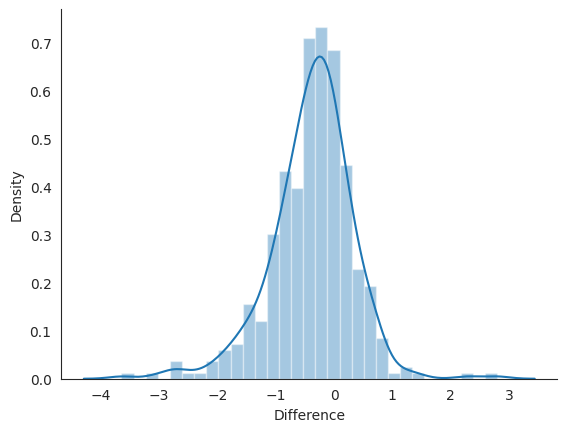

In [57]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

In [58]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


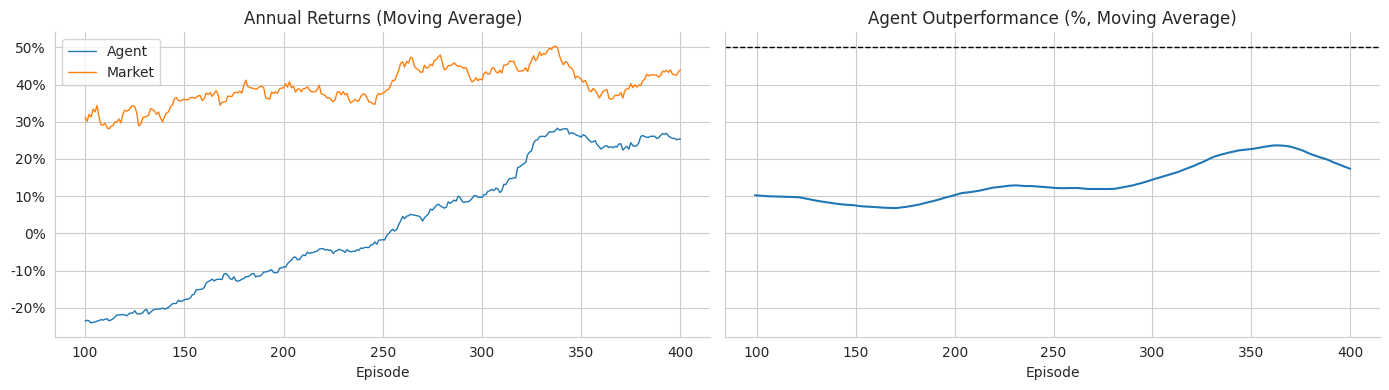

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path+'/performance_2', dpi=300)

In [60]:
agent_1_weights = ddqn_1.online_network.get_weights()

In [61]:
ddqn_1.online_network.save_weights(weights_path+'agent2_weights.h5')

# Agent 2


In [62]:
register(
    id='trading-v1-training',
    entry_point='training_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [63]:
register(
    id='trading-v1-evaluation',
    entry_point='evaluation_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [64]:
trading_cost_bps = 1e-4
time_cost_bps = 1e-4

In [65]:
f'Trading costs: {trading_cost_bps:.2%} | Time costs: {time_cost_bps:.2%}'

'Trading costs: 0.01% | Time costs: 0.01%'

In [66]:
trading_environment_training_2 = gym.make('trading-v1-training', ticker='AAPL', trading_days=252, trading_cost_bps=0.001, time_cost_bps=0.0001)
trading_environment_training_2.seed(42)

INFO:training_env:loading data for AAPL...
INFO:training_env:got data for AAPL...
INFO:training_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7914 entries, (Timestamp('1981-03-19 00:00:00'), 'AAPL') to (Timestamp('2012-07-31 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  7914 non-null   float64
 1   ret_2    7914 non-null   float64
 2   ret_5    7914 non-null   float64
 3   ret_10   7914 non-null   float64
 4   ret_21   7914 non-null   float64
 5   rsi      7914 non-null   float64
 6   macd     7914 non-null   float64
 7   atr      7914 non-null   float64
 8   stoch    7914 non-null   float64
 9   ultosc   7914 non-null   float64
dtypes: float64(10)
memory usage: 1.4+ MB


[42]

In [67]:
state_dim = trading_environment_training_2.observation_space.shape[0]
num_actions = trading_environment_training_2.action_space.n
max_episode_steps = trading_environment_training_2.spec.max_episode_steps

In [68]:
print("state dim:", state_dim)
print("num actions:", num_actions)
print("max episode steps:", max_episode_steps)

state dim: 10
num actions: 3
max episode steps: 252


In [69]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

In [70]:
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

In [71]:
replay_capacity = int(5e5)
batch_size = 256

In [72]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [73]:
tf.keras.backend.clear_session()

In [74]:
ddqn_2 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [75]:
ddqn_2.online_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               2816      
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 69379 (271.01 KB)
Trainable params: 69379 (271.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
total_steps = 0
max_episodes = 400

In [77]:
episode_time_2, navs_2, market_navs_2, diffs_2, episode_eps_2 = [], [], [], [], []

In [78]:
def track_results_2(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time_2[-100:]])
    T = np.sum(episode_time_2)

    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1,
                          market_nav_100-1, market_nav_10-1,
                          win_ratio, epsilon))

In [79]:
SOME_LARGE_VALUE = 5000  # arbitrary large value
start = time()
results = []
for episode in range(1, max_episodes + 1):
    total_reward = 0
    this_state = trading_environment_training_2.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn_2.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment_training_2.step(action)

        ddqn_2.memorize_transition(this_state,
                                 action,
                                 reward,
                                 next_state,
                                 0.0 if done else 1.0)
        if ddqn_2.train:
            ddqn_2.experience_replay()
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment_training_2.env.simulator.result()

    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav
    nav = final.nav * (1 + final.strategy_return)
    navs_2.append(nav)

    # market nav
    market_nav = final.market_nav
    market_navs_2.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs_2.append(diff)

    if episode % 5 == 0:
        track_results_2(episode,
                      # show mov. average results for 100 (10) periods
                      np.mean(navs_2[-100:]),
                      np.mean(navs_2[-10:]),
                      np.mean(market_navs_2[-100:]),
                      np.mean(market_navs_2[-10:]),
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs_2[-100:]])/min(len(diffs_2), 100),
                      time() - start, ddqn_2.epsilon)
    if len(diffs_2) > 25 and all([r > 0 for r in diffs_2[-25:]]):
        print(result.tail())
        break

trading_environment_training_2.close()

   5 | 00:02:15 | Agent: -14.7% (-14.7%) | Market:  34.1% ( 34.1%) | Wins: 20.0% | eps:  0.980
  10 | 00:04:50 | Agent: -23.4% (-23.4%) | Market:   9.1% (  9.1%) | Wins: 20.0% | eps:  0.960
  15 | 00:07:27 | Agent: -27.8% (-34.3%) | Market:  24.5% ( 19.6%) | Wins: 13.3% | eps:  0.941
  20 | 00:10:14 | Agent: -19.3% (-15.3%) | Market:  32.7% ( 56.3%) | Wins: 20.0% | eps:  0.921
  25 | 00:12:50 | Agent: -21.4% (-12.0%) | Market:  31.2% ( 41.2%) | Wins: 16.0% | eps:  0.901
  30 | 00:15:29 | Agent: -23.1% (-30.5%) | Market:  26.5% ( 14.1%) | Wins: 13.3% | eps:  0.881
  35 | 00:18:08 | Agent: -19.8% (-15.8%) | Market:  27.4% ( 18.2%) | Wins: 20.0% | eps:  0.861
  40 | 00:20:49 | Agent: -20.3% (-11.9%) | Market:  30.2% ( 41.4%) | Wins: 17.5% | eps:  0.842
  45 | 00:23:41 | Agent: -20.7% (-23.6%) | Market:  25.9% ( 20.4%) | Wins: 17.8% | eps:  0.822
  50 | 00:26:30 | Agent: -18.8% (-12.8%) | Market:  26.3% ( 10.6%) | Wins: 18.0% | eps:  0.802
  55 | 00:29:18 | Agent: -17.5% ( -3.3%) | Market:

In [80]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs_2,
                        'Market': market_navs_2,
                        'Difference': diffs_2}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(50).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


In [81]:
results.to_csv(results_path +'agent4_results.csv', index=False)

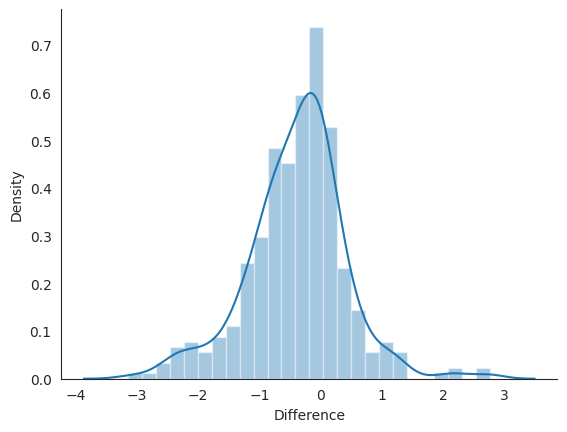

In [82]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

In [83]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


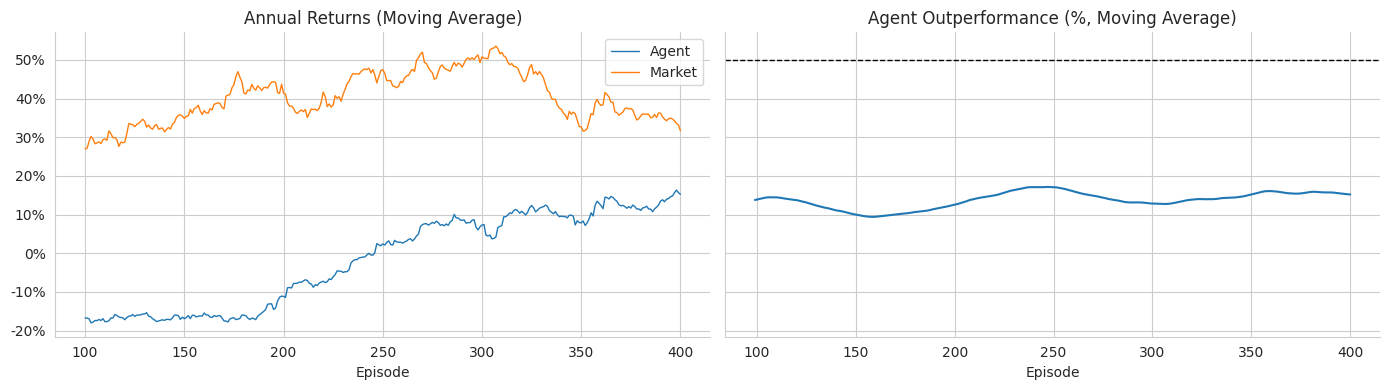

In [84]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path+'/performance_4', dpi=300)

In [85]:
agent_1_weights = ddqn_2.online_network.get_weights()

In [86]:
ddqn_2.online_network.save_weights(weights_path+'agent4_weights.h5')

In [111]:
total_steps = 0
max_episodes = 400

# Federated Round 1

## Agent 2

In [87]:
num_agents = 4
weight_saved = [f'/content/drive/My Drive/FYP/weights/agent{i+1}_weights.h5' for i in range(num_agents)]

In [88]:
ddqn_1 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [89]:
ddqn_2 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [90]:
ddqn_3 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [91]:
ddqn_4 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [92]:
ddqn_1.online_network.load_weights(weight_saved[0])
ddqn_2.online_network.load_weights(weight_saved[1])
ddqn_3.online_network.load_weights(weight_saved[2])
ddqn_4.online_network.load_weights(weight_saved[3])

In [93]:
loaded_weights = [ddqn_1.online_network.get_weights(), ddqn_2.online_network.get_weights(), ddqn_3.online_network.get_weights(), ddqn_4.online_network.get_weights()]

In [ ]:
print(loaded_weights)

In [95]:
average_weights = []

for weights_list in zip(*loaded_weights):
    layer_mean = np.mean(np.array(weights_list), axis=0)
    average_weights.append(layer_mean)

In [ ]:
print(average_weights)

In [100]:
register(
    id='trading-v0-training',
    entry_point='training_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [101]:
register(
    id='trading-v0-evaluation',
    entry_point='evaluation_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [102]:
trading_cost_bps = 1e-3
time_cost_bps = 5e-3

In [103]:
trading_environment_training = gym.make('trading-v0-training', ticker='AAPL', trading_days=252, trading_cost_bps=0.001, time_cost_bps=0.0001)
trading_environment_training.seed(42)

INFO:training_env:loading data for AAPL...
INFO:training_env:got data for AAPL...
INFO:training_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7914 entries, (Timestamp('1981-03-19 00:00:00'), 'AAPL') to (Timestamp('2012-07-31 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  7914 non-null   float64
 1   ret_2    7914 non-null   float64
 2   ret_5    7914 non-null   float64
 3   ret_10   7914 non-null   float64
 4   ret_21   7914 non-null   float64
 5   rsi      7914 non-null   float64
 6   macd     7914 non-null   float64
 7   atr      7914 non-null   float64
 8   stoch    7914 non-null   float64
 9   ultosc   7914 non-null   float64
dtypes: float64(10)
memory usage: 1.4+ MB


[42]

In [104]:
state_dim = trading_environment_training.observation_space.shape[0]
num_actions = trading_environment_training.action_space.n
max_episode_steps = trading_environment_training.spec.max_episode_steps

In [105]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

In [106]:
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

In [ ]:
replay_capacity = int(5e5)
batch_size = 256

In [107]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [108]:
tf.keras.backend.clear_session()

In [109]:
ddqn_1 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

ddqn_1.online_network.set_weights(average_weights)

In [110]:
ddqn_1.online_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               2816      
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 69379 (271.01 KB)
Trainable params: 69379 (271.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
episode_time_1, navs_1, market_navs_1, diffs_1, episode_eps_1 = [], [], [], [], []

In [113]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time_1[-100:]])
    T = np.sum(episode_time_1)

    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1,
                          market_nav_100-1, market_nav_10-1,
                          win_ratio, epsilon))

In [114]:
SOME_LARGE_VALUE = 5000  # arbitrary large value
start = time()
results = []
for episode in range(1, max_episodes + 1):
    total_reward = 0
    this_state = trading_environment_training.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn_1.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment_training.step(action)

        ddqn_1.memorize_transition(this_state,
                                 action,
                                 reward,
                                 next_state,
                                 0.0 if done else 1.0)
        if ddqn_1.train:
            ddqn_1.experience_replay()
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment_training.env.simulator.result()

    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav
    nav = final.nav * (1 + final.strategy_return)
    navs_1.append(nav)

    # market nav
    market_nav = final.market_nav
    market_navs_1.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs_1.append(diff)

    if episode % 5 == 0:
        track_results(episode,
                      # show mov. average results for 100 (10) periods
                      np.mean(navs_1[-100:]),
                      np.mean(navs_1[-10:]),
                      np.mean(market_navs_1[-100:]),
                      np.mean(market_navs_1[-10:]),
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs_1[-100:]])/min(len(diffs_1), 100),
                      time() - start, ddqn_1.epsilon)
    if len(diffs_1) > 25 and all([r > 0 for r in diffs_1[-25:]]):
        print(result.tail())
        break

trading_environment_training.close()

   5 | 00:02:36 | Agent:   1.2% (  1.2%) | Market:  17.5% ( 17.5%) | Wins: 40.0% | eps:  0.980
  10 | 00:05:30 | Agent: -19.2% (-19.2%) | Market:  38.8% ( 38.8%) | Wins: 20.0% | eps:  0.960
  15 | 00:08:41 | Agent: -19.0% (-29.2%) | Market:  33.9% ( 42.1%) | Wins: 20.0% | eps:  0.941
  20 | 00:11:40 | Agent: -13.3% ( -7.4%) | Market:  32.9% ( 27.0%) | Wins: 25.0% | eps:  0.921
  25 | 00:14:34 | Agent: -13.1% ( -4.3%) | Market:  39.9% ( 49.0%) | Wins: 24.0% | eps:  0.901
  30 | 00:17:37 | Agent: -17.4% (-25.6%) | Market:  37.0% ( 45.0%) | Wins: 23.3% | eps:  0.881
  35 | 00:20:40 | Agent: -18.6% (-32.3%) | Market:  34.8% ( 21.9%) | Wins: 22.9% | eps:  0.861
  40 | 00:23:40 | Agent: -19.4% (-25.3%) | Market:  29.1% (  5.4%) | Wins: 25.0% | eps:  0.842
  45 | 00:26:38 | Agent: -19.2% (-21.2%) | Market:  29.2% (  9.7%) | Wins: 24.4% | eps:  0.822
  50 | 00:29:38 | Agent: -18.4% (-14.3%) | Market:  24.4% (  5.5%) | Wins: 26.0% | eps:  0.802
  55 | 00:32:42 | Agent: -16.9% ( -6.4%) | Market:

In [115]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs_1,
                        'Market': market_navs_1,
                        'Difference': diffs_1}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(50).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


In [116]:
results.to_csv(results_path +'agent2_1_results.csv', index=False)

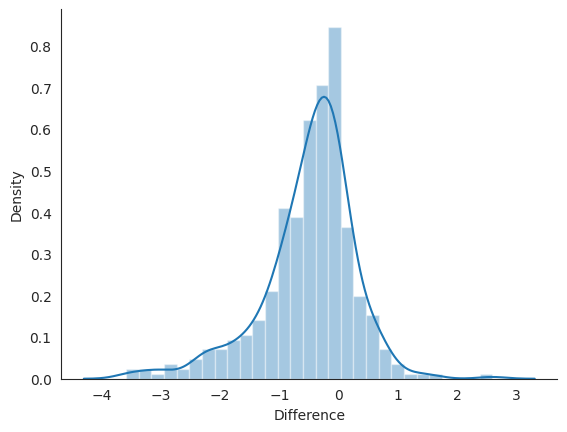

In [117]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

In [118]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


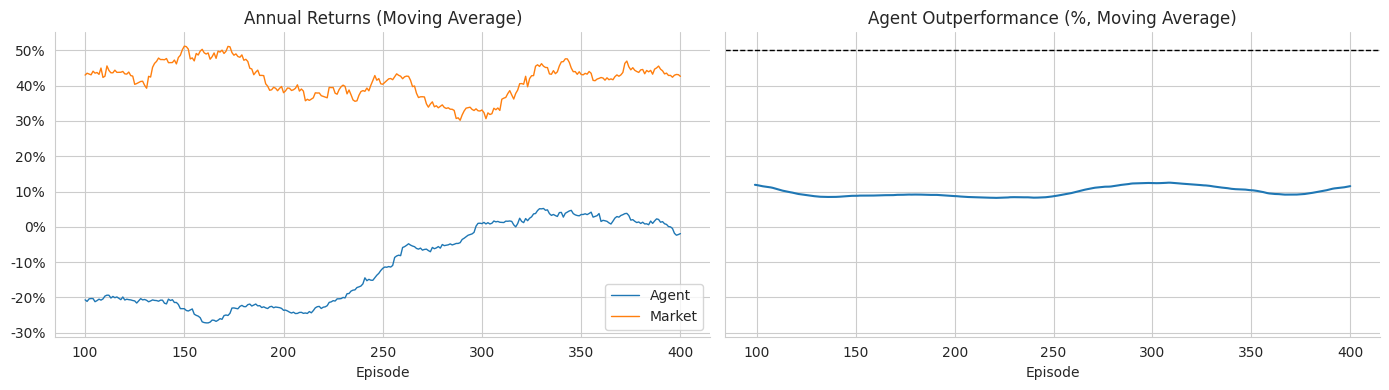

In [119]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path+'/performance_2_1', dpi=300)

In [120]:
ddqn_1.online_network.save_weights(weights_path+'agent2_1_weights.h5')

## Agent 4

In [121]:
register(
    id='trading-v1-training',
    entry_point='training_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [122]:
register(
    id='trading-v1-evaluation',
    entry_point='evaluation_env:TradingEnvironment',
    max_episode_steps=trading_days
)

In [123]:
trading_cost_bps = 1e-4
time_cost_bps = 1e-4

In [124]:
trading_environment_training_2 = gym.make('trading-v1-training', ticker='AAPL', trading_days=252, trading_cost_bps=0.001, time_cost_bps=0.0001)
trading_environment_training_2.seed(42)

INFO:training_env:loading data for AAPL...
INFO:training_env:got data for AAPL...
INFO:training_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7914 entries, (Timestamp('1981-03-19 00:00:00'), 'AAPL') to (Timestamp('2012-07-31 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  7914 non-null   float64
 1   ret_2    7914 non-null   float64
 2   ret_5    7914 non-null   float64
 3   ret_10   7914 non-null   float64
 4   ret_21   7914 non-null   float64
 5   rsi      7914 non-null   float64
 6   macd     7914 non-null   float64
 7   atr      7914 non-null   float64
 8   stoch    7914 non-null   float64
 9   ultosc   7914 non-null   float64
dtypes: float64(10)
memory usage: 1.4+ MB


[42]

In [125]:
state_dim = trading_environment_training.observation_space.shape[0]
num_actions = trading_environment_training.action_space.n
max_episode_steps = trading_environment_training.spec.max_episode_steps

In [126]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

In [127]:
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

In [128]:
replay_capacity = int(5e5)
batch_size = 256

In [129]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

In [130]:
tf.keras.backend.clear_session()

In [131]:
ddqn_2 = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

ddqn_2.online_network.set_weights(average_weights)

In [132]:
ddqn_2.online_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               2816      
                                                                 
 Dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Output (Dense)              (None, 3)                 771       
                                                                 
Total params: 69379 (271.01 KB)
Trainable params: 69379 (271.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
total_steps = 0
max_episodes = 400

In [134]:
episode_time_2, navs_2, market_navs_2, diffs_2, episode_eps_2 = [], [], [], [], []

In [135]:
def track_results_2(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time_2[-100:]])
    T = np.sum(episode_time_2)

    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total),
                          nav_ma_100-1, nav_ma_10-1,
                          market_nav_100-1, market_nav_10-1,
                          win_ratio, epsilon))

In [136]:
SOME_LARGE_VALUE = 5000  # arbitrary large value
start = time()
results = []
for episode in range(1, max_episodes + 1):
    total_reward = 0
    this_state = trading_environment_training_2.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn_2.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment_training_2.step(action)

        ddqn_2.memorize_transition(this_state,
                                 action,
                                 reward,
                                 next_state,
                                 0.0 if done else 1.0)
        if ddqn_2.train:
            ddqn_2.experience_replay()
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment_training_2.env.simulator.result()

    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav
    nav = final.nav * (1 + final.strategy_return)
    navs_2.append(nav)

    # market nav
    market_nav = final.market_nav
    market_navs_2.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs_2.append(diff)

    if episode % 5 == 0:
        track_results_2(episode,
                      # show mov. average results for 100 (10) periods
                      np.mean(navs_2[-100:]),
                      np.mean(navs_2[-10:]),
                      np.mean(market_navs_2[-100:]),
                      np.mean(market_navs_2[-10:]),
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs_2[-100:]])/min(len(diffs_2), 100),
                      time() - start, ddqn_2.epsilon)
    if len(diffs_2) > 25 and all([r > 0 for r in diffs_2[-25:]]):
        print(result.tail())
        break

trading_environment_training_2.close()

   5 | 00:02:33 | Agent:  -5.8% ( -5.8%) | Market:  69.5% ( 69.5%) | Wins: 20.0% | eps:  0.980
  10 | 00:05:15 | Agent:   3.6% (  3.6%) | Market:  50.0% ( 50.0%) | Wins: 20.0% | eps:  0.960
  15 | 00:07:58 | Agent:  -3.9% ( -3.0%) | Market:  38.4% ( 22.8%) | Wins: 20.0% | eps:  0.941
  20 | 00:10:46 | Agent: -11.4% (-26.3%) | Market:  33.3% ( 16.7%) | Wins: 20.0% | eps:  0.921
  25 | 00:13:26 | Agent: -15.6% (-33.1%) | Market:  35.2% ( 30.5%) | Wins: 20.0% | eps:  0.901
  30 | 00:16:11 | Agent: -16.9% (-28.1%) | Market:  36.6% ( 43.1%) | Wins: 23.3% | eps:  0.881
  35 | 00:18:59 | Agent: -16.9% (-20.2%) | Market:  36.6% ( 40.0%) | Wins: 22.9% | eps:  0.861
  40 | 00:21:49 | Agent: -17.9% (-20.7%) | Market:  36.6% ( 36.5%) | Wins: 22.5% | eps:  0.842
  45 | 00:24:38 | Agent: -19.5% (-28.5%) | Market:  37.7% ( 41.5%) | Wins: 20.0% | eps:  0.822
  50 | 00:27:42 | Agent: -17.5% (-16.2%) | Market:  37.5% ( 41.2%) | Wins: 22.0% | eps:  0.802
  55 | 00:30:36 | Agent: -16.7% ( -4.3%) | Market:

In [137]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs_2,
                        'Market': market_navs_2,
                        'Difference': diffs_2}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(50).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


In [138]:
results.to_csv(results_path +'agent4_1_results.csv', index=False)

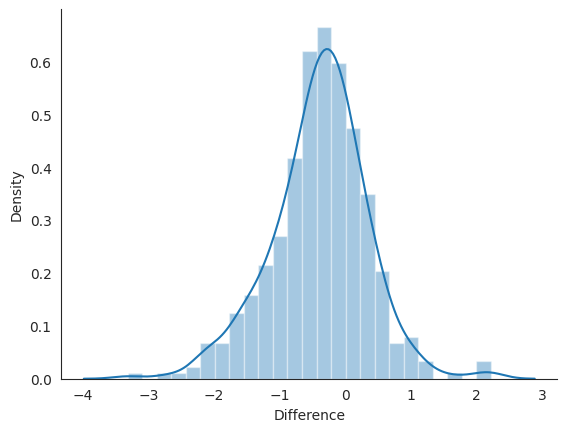

In [139]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

In [140]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              400 non-null    float64
 1   Market             400 non-null    float64
 2   Difference         400 non-null    float64
 3   Strategy Wins (%)  351 non-null    float64
dtypes: float64(4)
memory usage: 15.6 KB


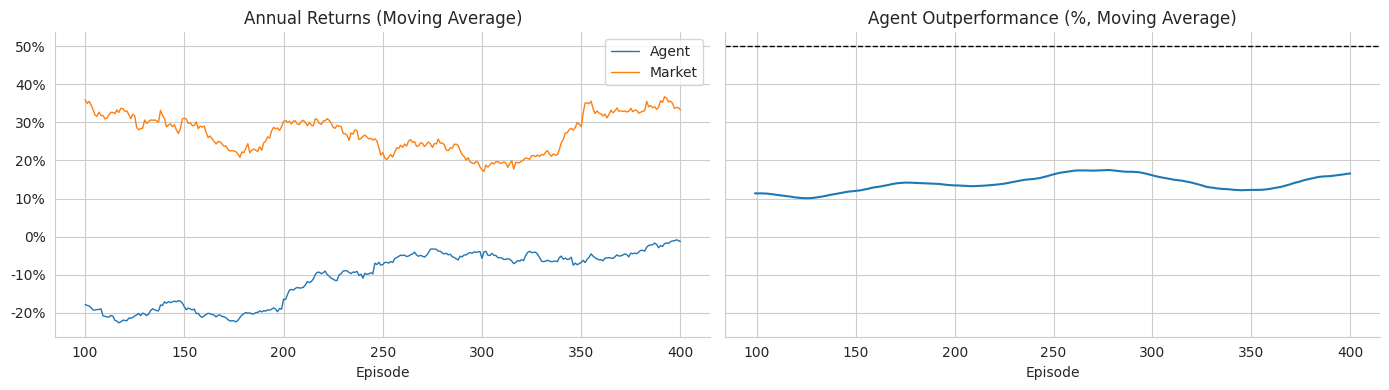

In [141]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path+'/performance_4_1', dpi=300)

In [142]:
ddqn_2.online_network.save_weights(weights_path+'agent4_1_weights.h5')